<a href="https://colab.research.google.com/github/akib26/TwitterSentimentAnalysis/blob/main/TWT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Positive words


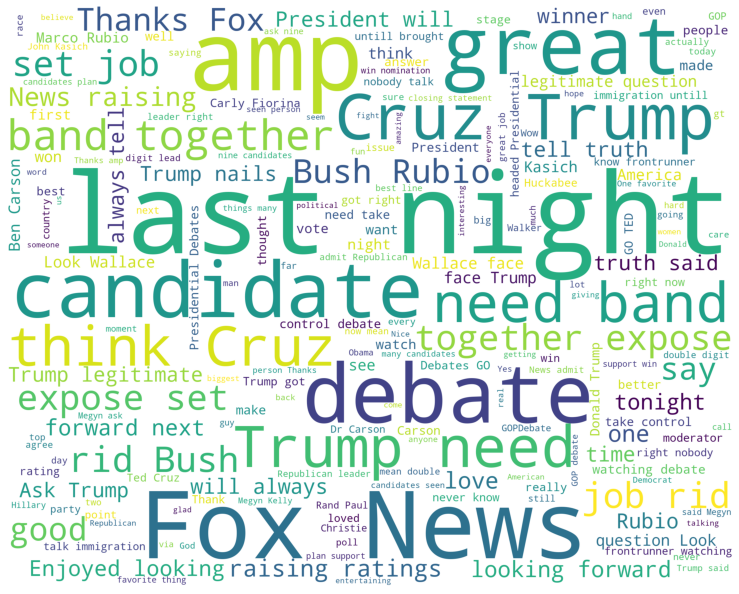

Negative words


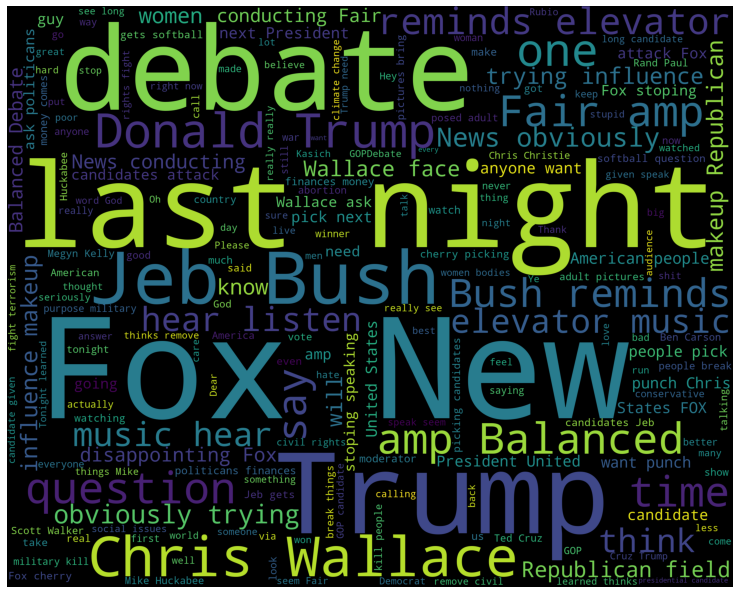

Neutral words


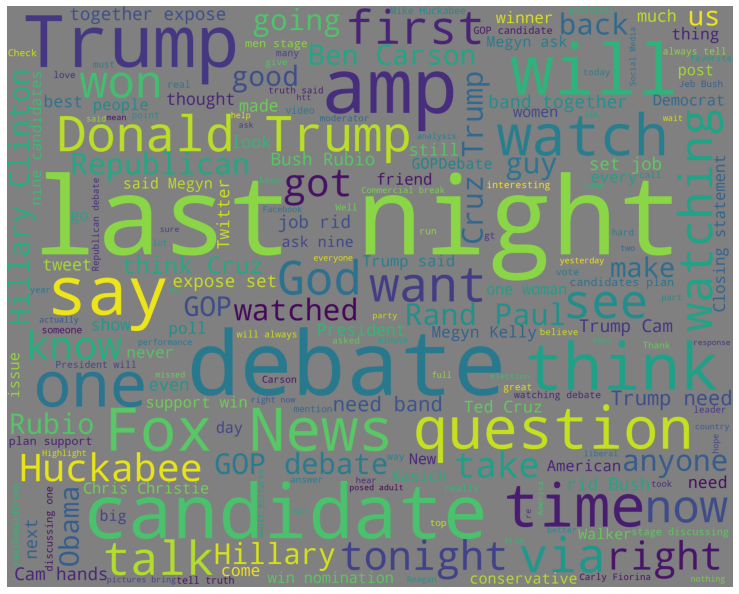

13274    High lofty expectations! #Jeb Jeb Jeb! Where's...
4082     DelilahNoBSzone: RT RedNationRising: Congrats ...
8308     RT @kwrcrow: Congrats to @realDonaldTrump for ...
1725     RT @JacobEngels: .@realDonaldTrump is winning....
11338    RT @RWSurferGirl: Thanks Fox News, you're rais...
                               ...                        
7032     I wouldn't mind John Kasich as my next preside...
4132     RT @AmyMek: Thank you @tedcruz for calling out...
8652     RT @Lrihendry: #TedCruz headed into the Presid...
1381     RT @Raiden679: Good explanation as to why #Tru...
5937     RT @Steve_Girschle: Impressive performance by ...
Name: text, Length: 215, dtype: object
5455     Dr. King says his dream became a nightmare... ...
9223     RT @UnitedCitizen01: @FOXNEWS #GOPdebates\n\nF...
3812     adamkareem: Was that a #GOPDebate last night? ...
9024     RT @RWSurferGirl: It is very disappointing tha...
6563     RT @LotusTom: FOX news last night revealed the...
                 

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt


data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']
train_neu = train[ train['sentiment'] == 'Neutral']
train_neu = train_neu['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)
print("Neutral words")
wordcloud_draw(train_neu,'grey')
tweets = []
stopwords_set = set(stopwords.words("english"))
 
for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))
 
test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
print(test_pos)
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']
print(test_neg)
test_neu = test[ test['sentiment'] == 'Neutral']
test_neu = test_neu['text']
print(test_neu)


# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all
 
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))
 
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

'''
neg_cnt = 0
pos_cnt = 0
neu_cnt=0
for obj in test_neu: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Neutral'): 
        neu_cnt = neu_cnt + 1
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))
print('[Neutral]: %s/%s '  % (len(test_neu),neu_cnt))
'''

In [12]:
test.shape

(1388, 2)

In [23]:
test.columns

Index(['text', 'sentiment'], dtype='object')

In [10]:
print(test.head())

                                                    text sentiment
5455   Dr. King says his dream became a nightmare... ...  Negative
3920   RT @SissonJack: Huckabee: “Reagan said ‘trust ...   Neutral
11980             Guuuurl Megyn go in on him #GOPDebates   Neutral
7599   My reaction, and that of @CatoInstitute collea...   Neutral
9223   RT @UnitedCitizen01: @FOXNEWS #GOPdebates\n\nF...  Negative


In [11]:
print(train.head())

                                                    text sentiment
6448   Donald Trump won viewers' attention during the...  Positive
12067  RT @RWSurferGirl: The candidates don't have to...  Negative
13620  RT @SupermanHotMale: NO MORE BUSHS... FUCK YOU...  Negative
7240   RT @scottjohnson: Is there a stinger after the...  Negative
7884   An unconventional way to watch the #GOPdebate ...   Neutral


In [17]:
predicted=[]
for obj in test['text']:
  res=classifier.classify(extract_features(obj.split()))
  predicted.append(res)

In [20]:
testset=test['sentiment'].tolist()

In [22]:
from nltk.metrics import ConfusionMatrix
print(ConfusionMatrix(testset, predicted).pretty_format(sort_by_count=True))

         |   N       P |
         |   e   N   o |
         |   g   e   s |
         |   a   u   i |
         |   t   t   t |
         |   i   r   i |
         |   v   a   v |
         |   e   l   e |
---------+-------------+
Negative |<765> 55  29 |
 Neutral | 211 <90> 23 |
Positive | 105  30 <80>|
---------+-------------+
(row = reference; col = test)



The numbers embedded in <> are the true positives (tp)meaning correctly classified.


*   rows refer to actual test set sentiment
*   columns refer to predicted sentiment by our naive bayes classifier





In [24]:
import pickle
mymodel = 'naive_finalized_model.sav'
pickle.dump(classifier, open(mymodel, 'wb'))

In [ ]:
from facebook_scraper import get_posts
 
listposts = []
for post in get_posts("anyfacebookpage", pages=2):
    print(post['text'][:50])
    listposts.append(post)
import os
from google.cloud import language_v1
from google.cloud.language_v1 import enums
from google.cloud import language
from google.cloud.language import types
 
 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "yourNLPAPIkey"
client = language_v1.LanguageServiceClient()
 
for x in range (len(listposts)):
    
    try:
 
        document = types.Document(content=listposts[x]["text"], type=enums.Document.Type.PLAIN_TEXT)
        sentiment = client.analyze_sentiment(document=document).document_sentiment
        sscore = round(sentiment.score,4)
        smag = round(sentiment.magnitude,4)
 
        listposts[x]["score"] = sscore
        listposts[x]["magnitude"] = smag
        
    except Exception as e:
        print(e)
        listposts[x]["score"] = 0
        listposts[x]["magnitude"] = 0
 import pandas as pd 
df = pd.DataFrame(listposts)
df.to_excel('<filename>.xlsx', header=True, index=False)
from scipy import stats
 
listlikes = []
listscore = []
listmagnitude= []
 
for x in listposts:
    listlikes.append(x["likes"])
    listscore.append(x["score"])
    listmagnitude.append(x["magnitude"])
    correlation, p_value = stats.pearsonr(listmagnitude, listlikes)    